Conhecendo os dados

**Dicionário:**

1. Age: idade do paciente (anos)

2. Sex: sexo do paciente [M: masculino, F: feminino]

3. ChestPainType: tipo de dor no peito [TA: Angina Típica, ATA: Angina Atípica, NAP: Dor Não Anginal, ASY: Assintomático] 

4. RestingBP: pressão arterial em repouso [mm Hg]

5. Cholesterol: colesterol sérico [mm/dl]

6. FastingBS: glicemia em jejum [1: se FastingBS > 120 mg/dl, 0: caso contrário]

7. RestingECG: resultados do eletrocardiograma em repouso [Normal: Normal, ST: presença de anormalidade na onda ST-T (inversões da onda T e/ou elevação ou depressão do segmento ST > 0,05 mV), LVH: indica hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes]

8. MaxHR: frequência cardíaca máxima alcançada [valor numérico entre 60 e 202]

9. ExerciseAngina: angina induzida por exercício [Y: Sim, N: Não]

10. Oldpeak: oldpeak = ST [valor numérico medido em depressão]

11. ST_Slope: inclinação do segmento ST no pico do exercício [Up: ascendente, Flat: plano, Down: descendente]

12. HeartDisease: classe de saída [1: doença cardíaca, 0: Normal]

In [40]:
import pandas as pd
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt
from geopy.distance import geodesic 
from scipy.spatial import KDTree
import csv
import re
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, recall_score, r2_score, mean_squared_error, mean_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from branca.colormap import StepColormap
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import joblib

import warnings
warnings.filterwarnings("ignore")

In [41]:
df_heart = pd.read_csv('heart.csv')
df_heart.head(4)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1


In [42]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [43]:
df_heart.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


# Análise Exploratória dos Dados (EDA):

Definindo funções complementares para plotagem

In [44]:
#funções para plotagem
def create_countplot(data, ax, title, xlabel='', ylabel='Quantidade', palette='Dark2'):
    sns.countplot(data=data, x='HeartDisease', ax=ax, palette=palette)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Saudáveis', 'Doentes'])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

def create_histogram(data, ax, title, xlabel, ylabel, color='red', bins=10, kde=False):
    sns.histplot(data=data, x='Age', ax=ax, bins=bins, color=color, kde=kde, edgecolor='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def create_angina_countplot(data, ax, title, xlabel='', ylabel='Quantidade', palette='Dark2'):
    sns.countplot(data=data, x='ChestPainType', ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

def create_scatterplot(data, ax, title, xlabel, ylabel, hue=None, palette='Dark2'):
    sns.scatterplot(data=data, x='Age', y='FastingBS', ax=ax, hue=hue, palette=palette)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def create_boxplot(data, ax, title, xlabel, ylabel, x='HeartDisease', y='RestingBP', hue=None):
    sns.boxplot(data=data, x=x, y=y, ax=ax, hue=hue, palette='Set2')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def create_kdeplot(data, ax, title, xlabel, ylabel, x='MaxHR', hue='HeartDisease'):
    sns.kdeplot(data=data, x=x, ax=ax, hue=hue, palette='Dark2', fill=True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def create_heatmap(data, ax, title):
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    corr = numeric_data.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='Dark2', ax=ax)
    ax.set_title(title)

def create_piechart(data, ax, title, labels, sizes):
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    ax.set_title(title)

def create_violinplot(data, ax, title, xlabel, ylabel, x='HeartDisease', y='MaxHR', hue=None):
    sns.violinplot(data=data, x=x, y=y, ax=ax, hue=hue, palette='Set3', split=True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def create_restingecg_countplot(data, ax, title, xlabel='', ylabel='Quantidade', palette='Dark2'):
    sns.countplot(data=data, x='RestingECG', ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

def create_restingecg_age_scatterplot(data, ax, title, xlabel, ylabel, hue='RestingECG', palette='Dark2'):
    sns.scatterplot(data=data, x='Age', y='RestingECG', ax=ax, hue=hue, palette=palette)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

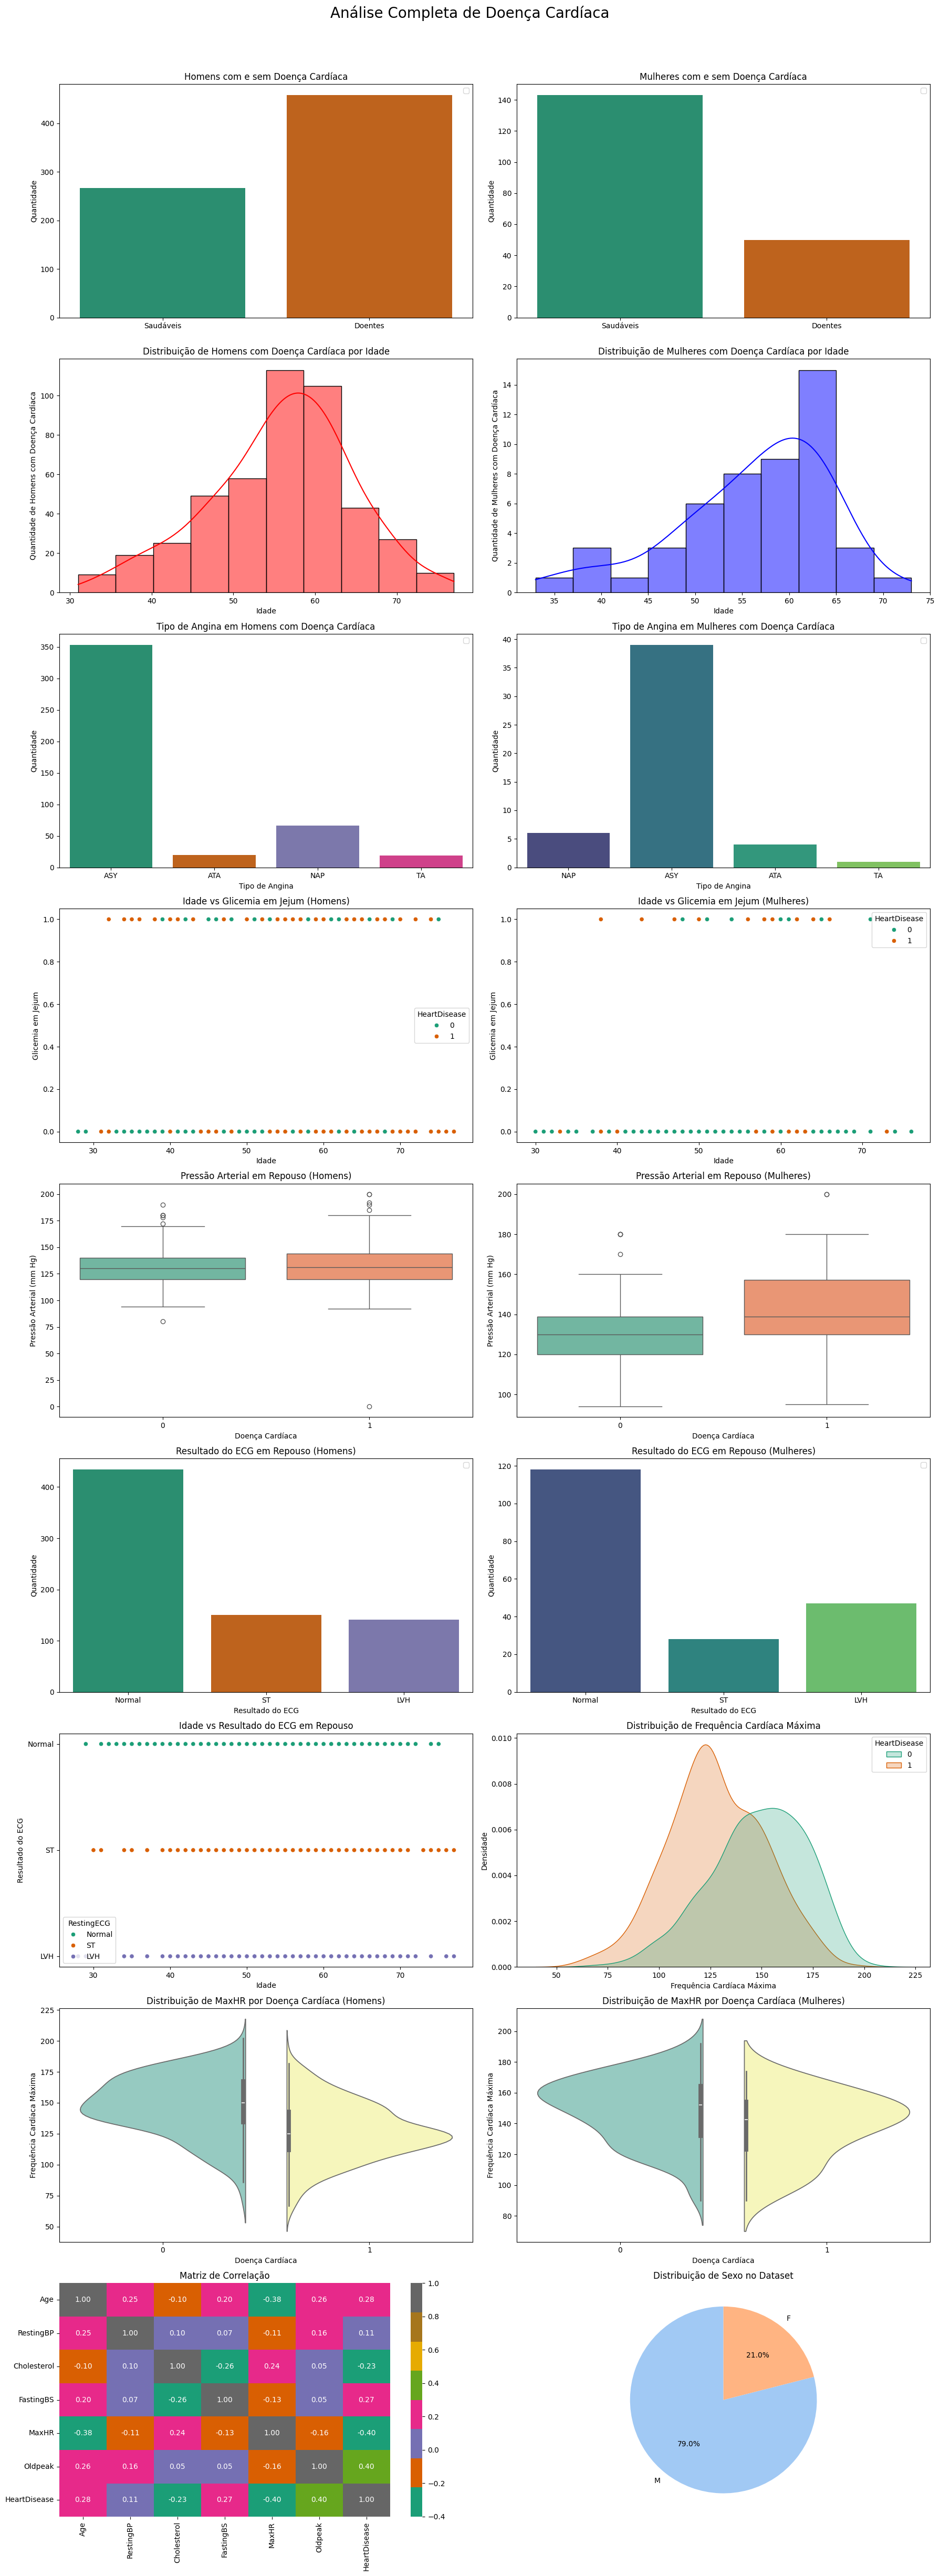

In [45]:
#para criar os subplots
fig, axes = plt.subplots(9, 2, figsize=(18, 50))
fig.suptitle('Análise Completa de Doença Cardíaca', fontsize=20)

#gráficos de contagem para doença cardíaca por sexo
create_countplot(df_heart[df_heart['Sex'] == 'M'], axes[0, 0], 'Homens com e sem Doença Cardíaca')
create_countplot(df_heart[df_heart['Sex'] == 'F'], axes[0, 1], 'Mulheres com e sem Doença Cardíaca')

#gráficos de distribuição de idade por sexo e doença cardíaca
create_histogram(df_heart[(df_heart['Sex'] == 'M') & (df_heart['HeartDisease'] == 1)], 
                 axes[1, 0], 'Distribuição de Homens com Doença Cardíaca por Idade', 
                 'Idade', 'Quantidade de Homens com Doença Cardíaca', kde=True)

create_histogram(df_heart[(df_heart['Sex'] == 'F') & (df_heart['HeartDisease'] == 1)], 
                 axes[1, 1], 'Distribuição de Mulheres com Doença Cardíaca por Idade', 
                 'Idade', 'Quantidade de Mulheres com Doença Cardíaca', color='blue', kde=True)

#gráficos de contagem para tipo de angina por sexo
create_angina_countplot(df_heart[(df_heart['Sex'] == 'M') & (df_heart['HeartDisease'] == 1)], 
                        axes[2, 0], 'Tipo de Angina em Homens com Doença Cardíaca', 
                        'Tipo de Angina', 'Quantidade')

create_angina_countplot(df_heart[(df_heart['Sex'] == 'F') & (df_heart['HeartDisease'] == 1)], 
                        axes[2, 1], 'Tipo de Angina em Mulheres com Doença Cardíaca', 
                        'Tipo de Angina', 'Quantidade', palette='viridis')

#gráficos de dispersão: Age vs FastingBS (separados por sexo)
create_scatterplot(df_heart[df_heart['Sex'] == 'M'], 
                   axes[3, 0], 'Idade vs Glicemia em Jejum (Homens)', 
                   'Idade', 'Glicemia em Jejum', hue='HeartDisease')

create_scatterplot(df_heart[df_heart['Sex'] == 'F'], 
                   axes[3, 1], 'Idade vs Glicemia em Jejum (Mulheres)', 
                   'Idade', 'Glicemia em Jejum', hue='HeartDisease')

#boxplot de Pressão Arterial em Repouso para Homens
create_boxplot(df_heart[df_heart['Sex'] == 'M'], axes[4, 0], 
               'Pressão Arterial em Repouso (Homens)', 
               'Doença Cardíaca', 'Pressão Arterial (mm Hg)')

#boxplot de Pressão Arterial em Repouso para Mulheres
create_boxplot(df_heart[df_heart['Sex'] == 'F'], axes[4, 1], 
               'Pressão Arterial em Repouso (Mulheres)', 
               'Doença Cardíaca', 'Pressão Arterial (mm Hg)')

#gráficos de contagem para RestingECG por sexo
create_restingecg_countplot(df_heart[df_heart['Sex'] == 'M'], axes[5, 0], 
                            'Resultado do ECG em Repouso (Homens)', 
                            'Resultado do ECG', 'Quantidade')

create_restingecg_countplot(df_heart[df_heart['Sex'] == 'F'], axes[5, 1], 
                            'Resultado do ECG em Repouso (Mulheres)', 
                            'Resultado do ECG', 'Quantidade', palette='viridis')

#gráfico de dispersão: Age vs RestingECG
create_restingecg_age_scatterplot(df_heart, axes[6, 0], 
                                  'Idade vs Resultado do ECG em Repouso', 
                                  'Idade', 'Resultado do ECG')

#gráfico de Densidade para Frequência Cardíaca Máxima
create_kdeplot(df_heart, axes[6, 1], 'Distribuição de Frequência Cardíaca Máxima', 
               'Frequência Cardíaca Máxima', 'Densidade')

#gráficos de Violino: MaxHR por HeartDisease (separados por sexo)
create_violinplot(df_heart[df_heart['Sex'] == 'M'], axes[7, 0], 
                  'Distribuição de MaxHR por Doença Cardíaca (Homens)', 
                  'Doença Cardíaca', 'Frequência Cardíaca Máxima')

create_violinplot(df_heart[df_heart['Sex'] == 'F'], axes[7, 1], 
                  'Distribuição de MaxHR por Doença Cardíaca (Mulheres)', 
                  'Doença Cardíaca', 'Frequência Cardíaca Máxima')

#gráfico de Correlação (Heatmap)
create_heatmap(df_heart, axes[8, 0], 'Matriz de Correlação')

#gráfico de Pizza para Distribuição de Sexo
sex_counts = df_heart['Sex'].value_counts()
create_piechart(df_heart, axes[8, 1], 'Distribuição de Sexo no Dataset', 
                labels=sex_counts.index, sizes=sex_counts.values)

#ajustes finais
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Treinando modelos de regressão para previsão de doenças cardíacas

Ajustando as colunas

In [46]:
df_heart_m = df_heart.copy()

In [47]:
df_heart_m.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [48]:
df_heart_m.duplicated().any()

False

Detectando outliers

In [49]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers.shape[0],outliers.index

In [50]:
count,outlier_indices = detect_outliers(df_heart_m, 'Age')

outlier_rows = df_heart.loc[outlier_indices]
print(count)
print(outlier_rows)

0
Empty DataFrame
Columns: [Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope, HeartDisease]
Index: []


Manipulando variáveis categórias

In [51]:
df_heart_m['Sex'] = df_heart_m['Sex'].replace({'M': 1, 'F': 2})


In [52]:
df_heart_m['ST_Slope'] = df_heart_m['ST_Slope'].replace({'Up': 0, 'Flat': 1, 'Down': 3})

In [53]:
df_heart_m['ExerciseAngina'] = df_heart_m['ExerciseAngina'].replace({'N': 0, 'Y': 1}).fillna(0).astype(int)


In [54]:
df_heart_m['ChestPainType'] = df_heart_m['ChestPainType'].replace({'TA': 1, 'ATA': 2, 'NAP': 3, 'ASY': 4}).fillna(0).astype(int)

In [55]:
df_heart_m.corr(numeric_only=True)['HeartDisease'].sort_values()

MaxHR            -0.400421
Sex              -0.305445
Cholesterol      -0.232741
RestingBP         0.107589
FastingBS         0.267291
Age               0.282039
Oldpeak           0.403951
ST_Slope          0.470304
ChestPainType     0.471354
ExerciseAngina    0.494282
HeartDisease      1.000000
Name: HeartDisease, dtype: float64

In [56]:
df = pd.read_csv("heart_model.csv", index_col=0)


In [57]:
#carrega os dados que serão utilizados para o teste
def load_data(file_path):
    return pd.read_csv(file_path)

In [58]:
#separa as features (X) do target (y) e seta o que estiver vazio como 0
def preprocess_data(df, target_column, drop_columns = None):

    if drop_columns:
        df = df.drop(drop_columns, axis=1)
    
    df = df.fillna(0)
    
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    return X, y
        

In [59]:
#divide os dados me um conjunto de treino e um conjunto de testes, além de aplicar scaling
def split_and_scale_data(X, y, test_size = 0.3, random_state = 10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, scaler

In [60]:
#seta as métricas que serão usadas para avaliar a qualidade do modelo: R^2, MAE e RMSE
def evaluate_model(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred  = model.predict(X_test)
    
    #define as métricas
    train_r2   = r2_score(y_train, train_pred)
    test_r2    = r2_score(y_test, test_pred)
    train_mae  = mean_absolute_error(y_train, train_pred)
    test_mae   = mean_absolute_error(y_test, test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test, test_pred))

    #printa todas as métricas depois de rodar determinado modelo 
    print(f"Modelo: {model.__class__.__name__}")
    print(f"  Treino - R²: {train_r2:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}")
    print(f"  Teste  - R²: {test_r2:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")
    print("-" * 50)

    return test_r2, model

In [61]:
df_heart_m.head(4)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,2,140,289,0,Normal,172,0,0.0,0,0
1,49,2,3,160,180,0,Normal,156,0,1.0,1,1
2,37,1,2,130,283,0,ST,98,0,0.0,0,0
3,48,2,4,138,214,0,Normal,108,1,1.5,1,1


In [62]:
df_heart_m = df_heart_m.drop(columns=['Unnamed: 0'], errors='ignore')


In [63]:
df_heart_m.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [64]:
if __name__ == "__main__":

    #carrega os dados que foram salvos para serem usados no modelo
    file_path = "heart_model.csv"  
    df = load_data(file_path)

    # realiza o pre-processamento dos dados
    target_column = "HeartDisease"  #define o target
    drop_columns  = "RestingECG"
    X, y          = preprocess_data(df, target_column, drop_columns)

    #separa e escala os dados
    X_train, X_test, y_train, y_test, scaler = split_and_scale_data(X, y)

    #define os modelos que serão utilizados
    modelos = {
        "XGBRegressor": XGBRegressor(),
        "Ridge": Ridge(),
        "RandomForestRegressor": RandomForestRegressor(),
        "LinearRegression": LinearRegression(),
        "ExtraTreesRegressor": ExtraTreesRegressor(),
        "LGBMRegressor": LGBMRegressor(), 
        "CatBoostRegressor": CatBoostRegressor(verbose=0)
    }

    #para encontrar o melhor modelo
    melhor_modelo_nome = None
    melhor_r2          = -np.inf
    melhor_modelo      = None

    for nome, modelo in modelos.items():
        print(f"Avaliando {nome}...")
        test_r2, modelo_treinado = evaluate_model(modelo, X_train, y_train, X_test, y_test)

    if test_r2 > melhor_r2:
        melhor_r2          = test_r2
        melhor_modelo_nome = nome
        melhor_modelo      = modelo_treinado    

    #salva em .pkl
    if melhor_modelo:
        joblib.dump(melhor_modelo, f"melhor_modelo_{melhor_modelo_nome}.pkl")
        joblib.dump(scaler, "scaler.pkl")  
        print(f"\n Melhor modelo: {melhor_modelo_nome} salvo como 'melhor_modelo_{melhor_modelo_nome}.pkl'")


Avaliando XGBRegressor...
Modelo: XGBRegressor
  Treino - R²: 0.9998, MAE: 0.0048, RMSE: 0.0073
  Teste  - R²: 0.5107, MAE: 0.2092, RMSE: 0.3486
--------------------------------------------------
Avaliando Ridge...
Modelo: Ridge
  Treino - R²: 0.4962, MAE: 0.2756, RMSE: 0.3524
  Teste  - R²: 0.4670, MAE: 0.2957, RMSE: 0.3639
--------------------------------------------------
Avaliando RandomForestRegressor...
Modelo: RandomForestRegressor
  Treino - R²: 0.9405, MAE: 0.0728, RMSE: 0.1211
  Teste  - R²: 0.5452, MAE: 0.2112, RMSE: 0.3361
--------------------------------------------------
Avaliando LinearRegression...
Modelo: LinearRegression
  Treino - R²: 0.4962, MAE: 0.2756, RMSE: 0.3524
  Teste  - R²: 0.4670, MAE: 0.2957, RMSE: 0.3639
--------------------------------------------------
Avaliando ExtraTreesRegressor...
Modelo: ExtraTreesRegressor
  Treino - R²: 1.0000, MAE: 0.0000, RMSE: 0.0000
  Teste  - R²: 0.5704, MAE: 0.1949, RMSE: 0.3267
---------------------------------------------

In [65]:
print(scaler.feature_names_in_)

['Unnamed: 0' 'Age' 'Sex' 'ChestPainType' 'RestingBP' 'Cholesterol'
 'FastingBS' 'MaxHR' 'ExerciseAngina' 'Oldpeak' 'ST_Slope']
